# Kontrolna tačka 2 – Analiza podataka, pretprocesiranje i baseline model


## 1. Uvod

U okviru ove kontrolne tačke fokus je na analizi i pripremi skupa podataka koji će biti korišten za treniranje generativnih modela u narednoj fazi projekta.
Cilj je da se kroz detaljnu analizu strukture podataka, vizuelnu inspekciju i osnovno pretprocesiranje uspostavi stabilna osnova za kasnije implementacije generativnih pristupa.

Pored analize i pripreme podataka, u ovoj fazi implementiran je i jednostavan klasifikacioni baseline model. Njegova svrha nije postizanje maksimalnih performansi, već provjera da li pripremljeni podaci sadrže dovoljno informacija za učenje osnovnih vizuelnih obrazaca, kao i identifikacija ograničenja koja proizilaze iz strukture i veličine skupa podataka.

## 2. Analiza i opis skupa podataka


### 2.1 Učitavanje i osnovna struktura skupa podataka
U ovom koraku učitavaju se CSV fajlovi koji opisuju strukturu skupa podataka. Fajl `index.csv` sadrži informacije o putanjama do slika i pripadajućim klasama za trening i validaciju, dok `test.csv` sadrži podatke za testiranje modela. Fajl `metadata.csv` obezbjeđuje dodatne informacije o klasama, uključujući nazive LEGO figurica, i koristi se isključivo za interpretaciju i vizualizaciju rezultata.


In [7]:
!unzip LEGO_GAN.zip -d /content/LEGO_GAN

Archive:  LEGO_GAN.zip
replace /content/LEGO_GAN/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [15]:
import pandas as pd
from pathlib import Path

ROOT = Path("/content/LEGO_GAN")

index_df = pd.read_csv(ROOT / "index.csv")
test_df  = pd.read_csv(ROOT / "test.csv")
meta_df  = pd.read_csv(ROOT / "metadata.csv", encoding="latin1")

print("Ucitano.")
print("index:", index_df.shape, "test:", test_df.shape, "meta:", meta_df.shape)


Ucitano.
index: (371, 2) test: (79, 2) meta: (38, 4)


### 2.2 Priprema putanja do slika i oznaka klasa
Nakon učitavanja podataka, relativne putanje do slika transformišu se u apsolutne putanje kako bi se omogućilo direktno učitavanje slika sa diska tokom treniranja modela.
Takođe, oznake klasa se prilagođavaju tako da započinju od nule, što predstavlja standardni zahtjev prilikom treniranja neuronskih mreža u TensorFlow okruženju.


In [16]:
index_df["filepath"] = index_df["path"].apply(lambda p: str(ROOT / p))
test_df["filepath"]  = test_df["path"].apply(lambda p: str(ROOT / p))

index_df["label"] = index_df["class_id"] - 1
test_df["label"]  = test_df["class_id"] - 1

index_df.head()


path  class_id                               filepath  label
0  marvel/0001/001.jpg         1  /content/LEGO_GAN/marvel/0001/001.jpg      0
1  marvel/0001/002.jpg         1  /content/LEGO_GAN/marvel/0001/002.jpg      0
2  marvel/0001/003.jpg         1  /content/LEGO_GAN/marvel/0001/003.jpg      0
3  marvel/0001/004.jpg         1  /content/LEGO_GAN/marvel/0001/004.jpg      0
4  marvel/0001/005.jpg         1  /content/LEGO_GAN/marvel/0001/005.jpg      0

### 2.3 Provjera integriteta skupa podataka
U ovom koraku vrši se provjera integriteta skupa podataka kako bi se osiguralo da sve putanje do slika iz trening i test skupa zaista postoje na disku. Ova provjera je važna kako bi se izbjegli potencijalni problemi tokom učitavanja podataka i treniranja modela, kao što su greške usljed nepostojećih ili oštećenih fajlova.


In [17]:
import os

missing_train = sum(not os.path.exists(fp) for fp in index_df["filepath"])
missing_test  = sum(not os.path.exists(fp) for fp in test_df["filepath"])

print("Missing train images:", missing_train)
print("Missing test images:", missing_test)


Missing train images: 0
Missing test images: 0


### 2.4 Vizualizacija uzoraka iz skupa podataka
Radi boljeg razumijevanja skupa podataka, izvršena je vizualizacija nekoliko nasumično odabranih uzoraka iz različitih klasa.
Prikazani primjeri omogućavaju uvid u izgled LEGO figurica, kao i u varijacije koje postoje unutar iste klase, uključujući razlike u: **pozadini**, **osvjetljenju**, **pozi i orijentaciji figurice**, **prisutnosti dodatnih rekvizita**.

Vizuelna inspekcija ukazuje na visok stepen intra-klasne varijabilnosti, što predstavlja izazov za klasifikaciju, naročito u uslovima ograničenog broja uzoraka po klasi.


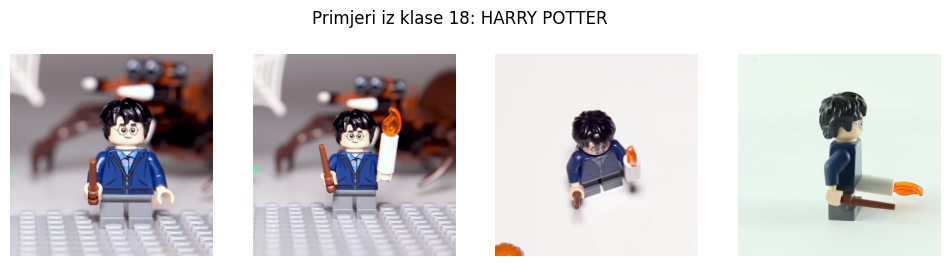

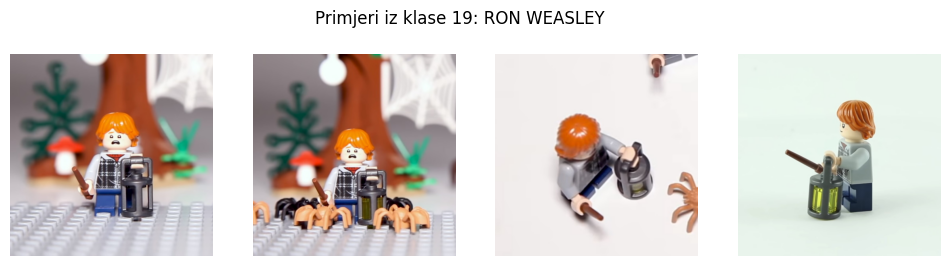

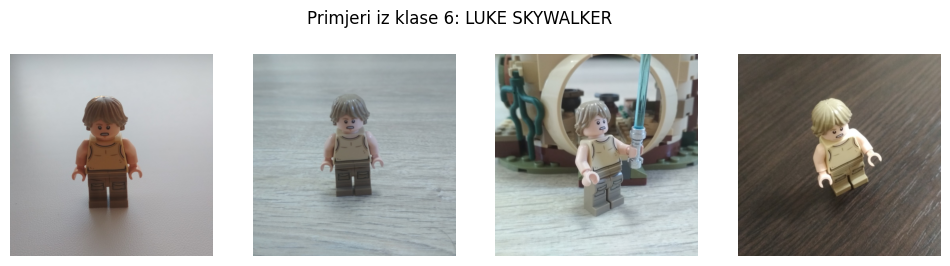

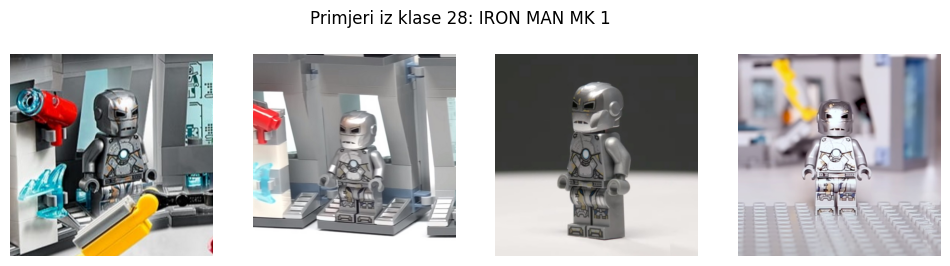

In [18]:
import matplotlib.pyplot as plt
from PIL import Image

def show_examples(df, class_id, n=4):
    sample = df[df["class_id"] == class_id].sample(n, random_state=1)
    plt.figure(figsize=(12,3))
    for i, fp in enumerate(sample["filepath"], 1):
        img = Image.open(fp).convert("RGB")
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.axis("off")
    name = meta_df.loc[meta_df["class_id"] == class_id, "minifigure_name"].values
    title = name[0] if len(name) else f"class {class_id}"
    plt.suptitle(f"Primjeri iz klase {class_id}: {title}")
    plt.show()

for cid in [18, 19, 6, 28]:
    show_examples(index_df, cid, n=4)


### 2.5 Raspodjela klasa u skupu podataka
Pored kvalitativne analize vizuelnih uzoraka, važno je ispitati i raspodjelu klasa u skupu podataka. Analiza broja uzoraka po klasi omogućava uvid u balansiranost dataset-a, što može imati značajan uticaj na treniranje i performanse modela. U nastavku je prikazana raspodjela slika po klasama za trening skup, kako bi se identifikovale eventualne neravnomjernosti koje bi mogle uticati na rezultate baseline modela.


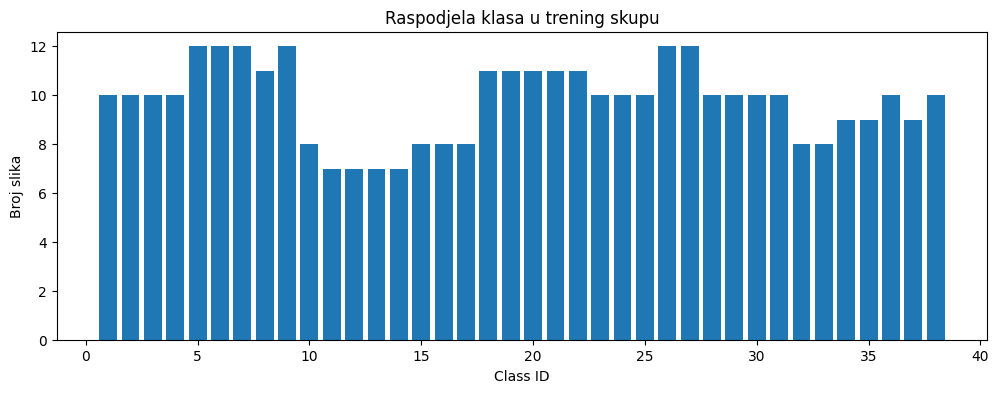

In [19]:
class_counts = index_df["class_id"].value_counts().sort_index()

plt.figure(figsize=(12,4))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Class ID")
plt.ylabel("Broj slika")
plt.title("Raspodjela klasa u trening skupu")
plt.show()


### 2.6 Nasumični grid uzoraka i prikaz najzastupljenijih / najmanje zastupljenih klasa

Kako bi se dodatno ilustrovala raznovrsnost podataka, prikazan je nasumični grid slika iz trening skupa, kao i odvojeni prikazi najzastupljenijih i najmanje zastupljenih klasa.

Ovi vizuelni prikazi dodatno potvrđuju da dataset nije uniforman, te da pojedine klase sadrže znatno manje uzoraka, što direktno utiče na performanse klasifikacionih modela.

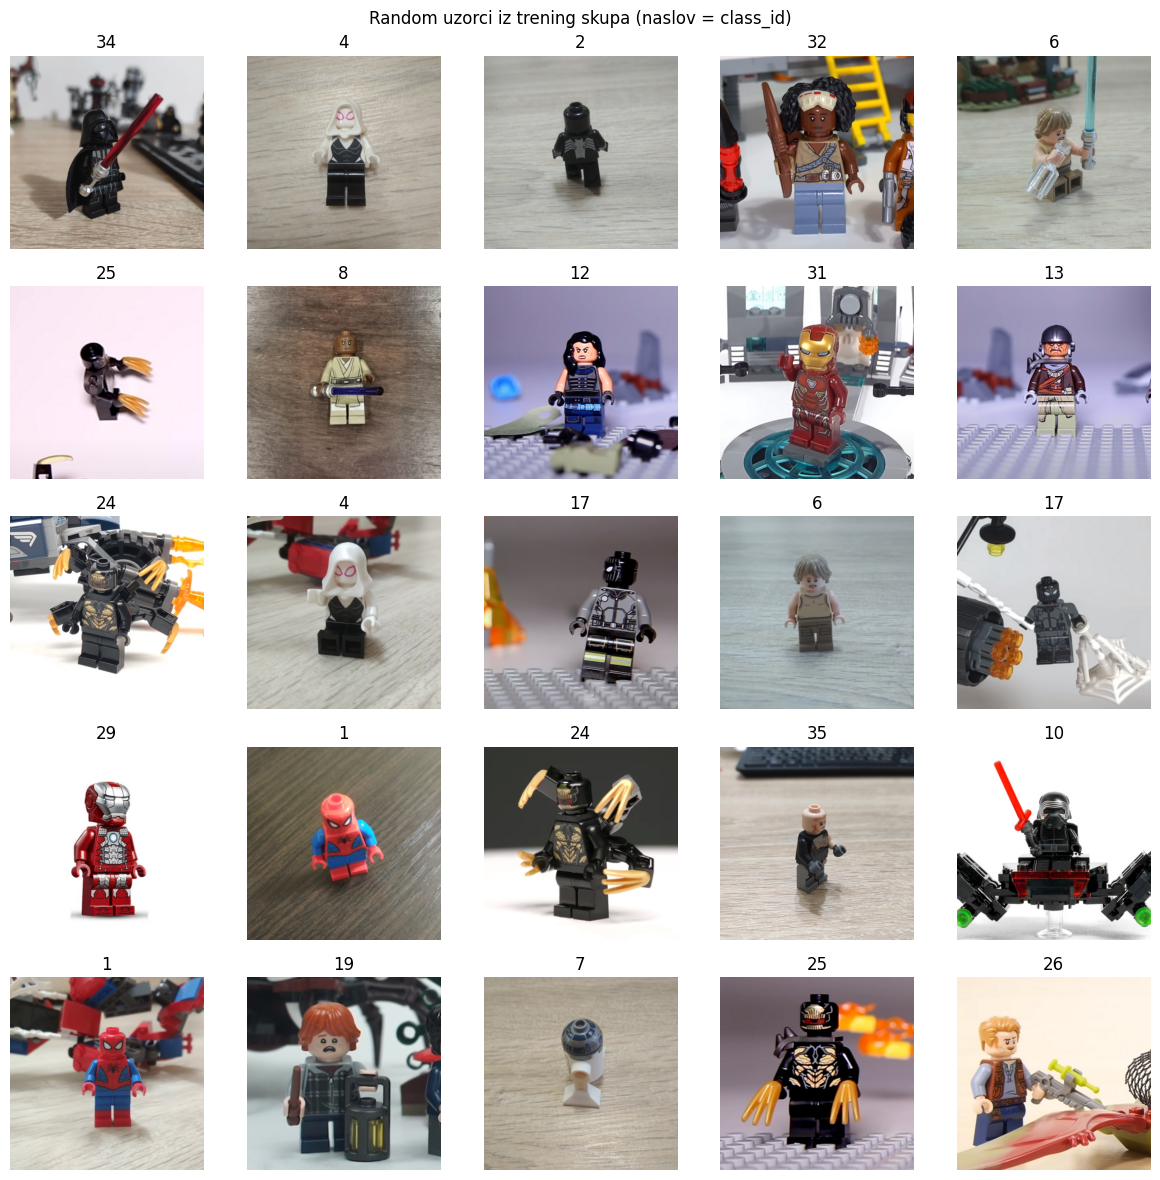

In [20]:
def show_random_grid(df, k=25, seed=42):
    sample = df.sample(k, random_state=seed)
    cols = 5
    rows = (k + cols - 1) // cols

    plt.figure(figsize=(12, 12))
    for i, (_, row) in enumerate(sample.iterrows(), 1):
        img = Image.open(row["filepath"]).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.title(int(row["class_id"]))
        plt.axis("off")
    plt.suptitle("Random uzorci iz trening skupa (naslov = class_id)")
    plt.tight_layout()
    plt.show()

show_random_grid(index_df, k=25)


### 2.7 Najzastupljenije i najmanje zastupljene klase

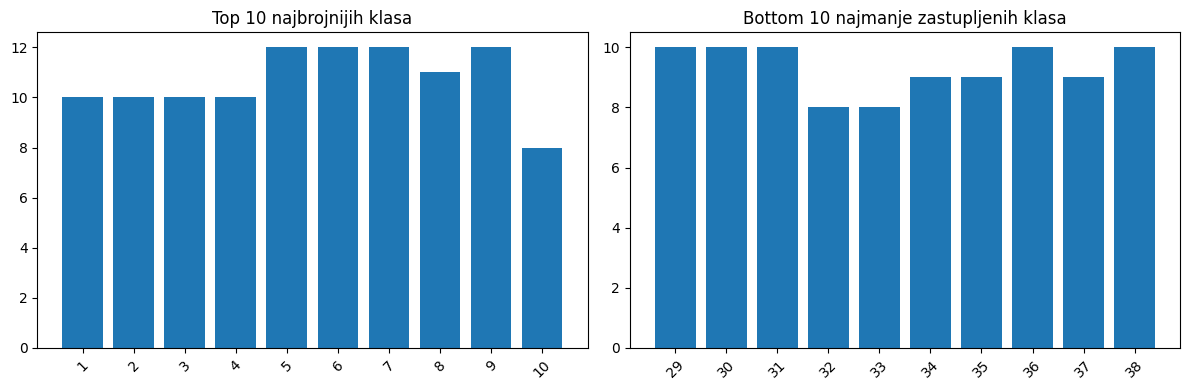

In [21]:
top10 = class_counts.head(10)
bot10 = class_counts.tail(10)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.bar(top10.index.astype(str), top10.values)
plt.title("Top 10 najbrojnijih klasa")
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(bot10.index.astype(str), bot10.values)
plt.title("Bottom 10 najmanje zastupljenih klasa")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 3. Pretprocesiranje i vizualizacija podataka

U ovoj fazi vrši se osnovno pretprocesiranje slika kako bi se podaci prilagodili zahtjevima neuronskih mreža. Cilj pretprocesiranja je da se obezbijedi uniforman format ulaznih podataka, smanji varijabilnost koja nije relevantna za zadatak i omogući stabilno treniranje modela. U nastavku su primijenjene standardne transformacije koje se često koriste u radu sa slikama, uključujući promjenu dimenzija i normalizaciju vrijednosti piksela.


### 3.1 Stratifikovana podjela skupa podataka
Trening skup se dijeli na trening i validacioni dio korištenjem stratifikovane podjele.
Na ovaj način se osigurava da raspodjela klasa u oba podskupa ostane približno ista, što je posebno važno u slučaju neuravnoteženih skupova podataka.

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

train_paths = index_df["filepath"].values
train_labels = index_df["label"].values

test_paths = test_df["filepath"].values
test_labels = test_df["label"].values

tr_p, val_p, tr_y, val_y = train_test_split(
    train_paths, train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

num_classes = len(np.unique(train_labels))
print("Train:", len(tr_p), "Val:", len(val_p), "Test:", len(test_paths))
print("num_classes:", num_classes)


Train: 296 Val: 75 Test: 79
num_classes: 38


### 3.2 Promjena dimenzija slika i normalizacija

U ovom koraku vrši se standardizacija ulaznih slika kako bi se podaci prilagodili zahtjevima konvolucionih neuronskih mreža. Budući da slike u skupu podataka dolaze u različitim dimenzijama i formatima, neophodno je izvršiti njihovu transformaciju u jedinstven oblik prije treniranja modela.

Sve slike se skaliraju na rezoluciju 64×64 piksela, čime se postiže kompromis između očuvanja osnovnih vizuelnih karakteristika i računske efikasnosti. Ova rezolucija je dovoljna za učenje globalnih vizuelnih obrazaca u okviru baseline modela, dok istovremeno omogućava brže treniranje i manju potrošnju memorije.

Pored promjene dimenzija, primjenjuje se i normalizacija vrijednosti piksela. Originalne vrijednosti piksela nalaze se u opsegu od 0 do 255, a u ovom radu one se skaliraju na opseg [0, 1]. Ova transformacija doprinosi stabilnijem procesu učenja, smanjuje oscilacije gradijenata i predstavlja standardnu praksu u dubokom učenju zasnovanom na slikama.


In [23]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

IMG_SIZE = 64

def decode_resize_normalize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label


### 3.3 Augmentacija podataka
S obzirom na ograničen broj dostupnih uzoraka, primijenjena je augmentacija podataka u cilju povećanja efektivne veličine trening skupa.
Augmentacija se primjenjuje isključivo nad trening podacima i uključuje umjerene transformacije kao što su: **horizontalno preslikavanje**, **promjene kontrasta i osvjetljenja**.

Prilikom dizajniranja augmentacije vodilo se računa da se ne naruši semantički sadržaj slike, naročito u kontekstu LEGO figurica gdje prevelike transformacije mogu ukloniti ključne vizuelne karakteristike.

In [24]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomContrast(0.12),
    tf.keras.layers.RandomBrightness(0.06),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomZoom(0.08),
], name="data_aug")

geo_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(0.04, 0.04),
    tf.keras.layers.RandomZoom(0.06),
], name="geo_aug")

def color_jitter(img):
    img = tf.image.random_brightness(img, max_delta=0.06)
    img = tf.image.random_contrast(img, lower=0.90, upper=1.10)
    return img

def augment(img, label):
    img = tf.expand_dims(img, 0)        # (1,H,W,3)
    img = geo_aug(img, training=True)
    img = tf.squeeze(img, 0)            # (H,W,3)

    img = color_jitter(img)

    img = tf.clip_by_value(img, 0.0, 1.0)
    return img, label



### 3.4 Formiranje tf.data skupova
Nakon definisanja transformacija nad slikama, podaci se organizuju korištenjem TensorFlow tf.data API-ja, koji omogućava efikasno i skalabilno rukovanje velikim skupovima podataka.

Kreirani su odvojeni skupovi za:

- **treniranje (ds_train)**,

- **validaciju (ds_val)** i

- **testiranje (ds_test)**.

Transformacije dekodiranja, promjene dimenzija i normalizacije primjenjuju se nad svim skupovima, dok se augmentacija koristi isključivo nad trening skupom. Na ovaj način se sprječava curenje informacija iz validacionog i test skupa u proces učenja, čime se obezbjeđuje objektivna evaluacija modela.

Podaci se grupišu u batch-eve fiksne veličine i dodatno optimizuju korištenjem mehanizama za paralelno učitavanje i prefetching. Ovakav pristup omogućava efikasnije iskorištavanje dostupnih računskih resursa i stabilnije treniranje modela bez potrebe za učitavanjem kompletnog skupa podataka u memoriju.

In [25]:
BATCH = 32

ds_train = tf.data.Dataset.from_tensor_slices((tr_p, tr_y))
ds_val   = tf.data.Dataset.from_tensor_slices((val_p, val_y))
ds_test  = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

ds_train = (ds_train
    .shuffle(2000)
    .map(decode_resize_normalize, num_parallel_calls=AUTOTUNE)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH)
    .prefetch(AUTOTUNE))

ds_val = (ds_val
    .map(decode_resize_normalize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH)
    .prefetch(AUTOTUNE))

ds_test = (ds_test
    .map(decode_resize_normalize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH)
    .prefetch(AUTOTUNE))


### 3.5 Vizualni pregled efekata augmentacije

Radi provjere ispravnosti augmentacije, izvršen je vizuelni prikaz originalnih i augmentiranih verzija istih slika.
Ovaj korak omogućava kvalitativnu procjenu da li augmentacija doprinosi raznovrsnosti podataka bez uvođenja nerealističnih deformacija.


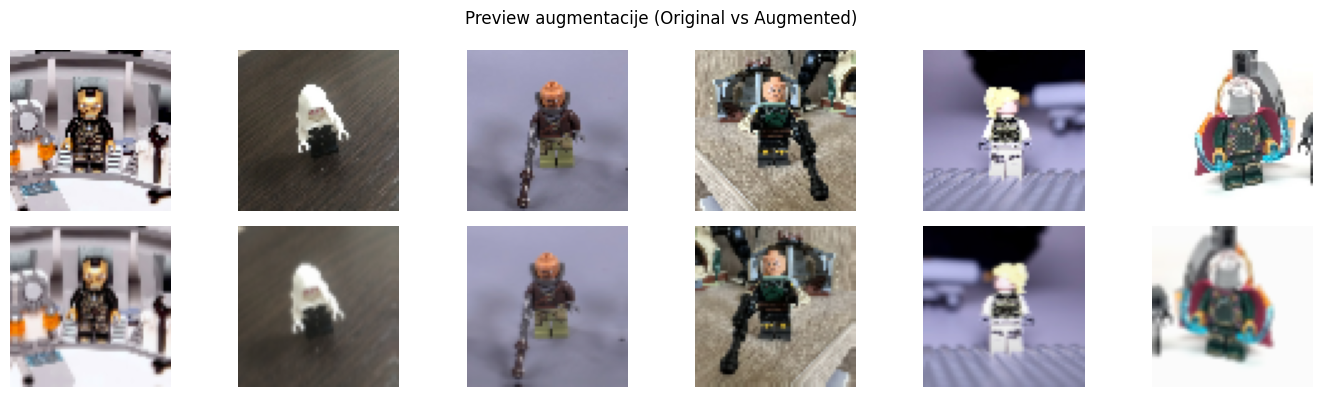

In [26]:
import matplotlib.pyplot as plt

def show_augmentation_preview(ds_raw, n=6):
    it = iter(ds_raw.take(n))
    plt.figure(figsize=(14, 4))
    for i in range(n):
        img, lab = next(it)
        aug_img, _ = augment(img, lab)

        plt.subplot(2, n, i+1)
        plt.imshow(img.numpy())
        plt.axis("off")

        plt.subplot(2, n, n+i+1)
        plt.imshow(aug_img.numpy())
        plt.axis("off")

    plt.suptitle("Preview augmentacije (Original vs Augmented)")
    plt.tight_layout()
    plt.show()

ds_preview = tf.data.Dataset.from_tensor_slices((tr_p, tr_y)).map(decode_resize_normalize)
show_augmentation_preview(ds_preview, n=6)


U ovom poglavlju izvršeno je sistematsko pretprocesiranje skupa podataka s ciljem prilagođavanja slika zahtjevima konvolucionih neuronskih mreža i obezbjeđivanja stabilnog procesa treniranja. Kroz stratifikovanu podjelu podataka osigurana je reprezentativnost trening i validacionih skupova, čime se smanjuje rizik od pristrasne evaluacije modela u uslovima neuravnotežene raspodjele klasa.

Standardizacijom dimenzija slika i normalizacijom vrijednosti piksela obezbijeđen je jedinstven format ulaznih podataka, što omogućava efikasno učenje i stabilniju optimizaciju modela. Posebna pažnja posvećena je dizajnu augmentacije podataka, pri čemu su primijenjene umjerene transformacije koje povećavaju raznovrsnost trening uzoraka bez narušavanja semantičkog sadržaja slika.

Ovim korakom uspostavljena je stabilna i metodološki ispravna osnova za treniranje baseline klasifikacionog modela u narednom poglavlju, kao i za dalje eksperimente koji uključuju složenije modele i generativne pristupe za proširenje skupa podataka.

## 4. Baseline model i rezultati (38 klasa)

### 4.1 Priprema podataka za treniranje baseline modela

U ovom koraku pripremljeni skupovi podataka iz prethodnog poglavlja koriste se kao ulaz za treniranje baseline klasifikacionog modela.
Podaci su organizovani u obliku tf.data.Dataset objekata, što omogućava efikasno učitavanje slika sa diska, primjenu definisanih transformacija i treniranje modela bez potrebe za učitavanjem kompletnog skupa podataka u memoriju.

Ovakav pristup predstavlja standardnu praksu u savremenim deep learning aplikacijama i posebno je pogodan za rad sa slikovnim podacima većih dimenzija.

### 4.2 Definisanje baseline CNN modela
Za potrebe evaluacije kvaliteta pripremljenih podataka i osnovnih vizuelnih obrazaca, implementiran je jednostavan konvolucioni neuronski model koji služi kao baseline.
Model je namjerno dizajniran bez složenih arhitektonskih komponenti, kako bi se izbjegao uticaj naprednih optimizacija i jasno sagledala ograničenja koja proizilaze iz samog skupa podataka.

Arhitektura modela sastoji se od više konvolucionih slojeva sa normalizacijom i nelinearnim aktivacijama, nakon čega slijedi globalno prosječno sažimanje i potpuno povezani slojevi za klasifikaciju.

In [27]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

def build_baseline_cnn(img_size=64, num_classes=38):
    inputs = layers.Input(shape=(img_size, img_size, 3))

    x = layers.Conv2D(32, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

model_38 = build_baseline_cnn(IMG_SIZE, num_classes)
model_38.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,558 (451.40 KB)

 Trainable params: 115,110 (449.65 KB)

 Non-trainable params: 448 (1.75 KB)

### 4.3 Kompajliranje i treniranje baseline modela (38 klasa)
Model se kompajlira korištenjem Adam optimizatora i funkcije gubitka pogodne za višeklasnu klasifikaciju sa cjelobrojnim oznakama klasa.
Tokom treniranja primijenjene su tehnike ranog zaustavljanja i adaptivnog smanjenja stope učenja kako bi se spriječilo prekomjerno prilagođavanje modela trening podacima.

In [28]:
model_38.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, verbose=1)

history_38 = model_38.fit(
    ds_train,
    validation_data=ds_val,
    epochs=40,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 429ms/step - accuracy: 0.0341 - loss: 4.0569 - val_accuracy: 0.0400 - val_loss: 3.6338 - learning_rate: 5.0000e-04
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 607ms/step - accuracy: 0.0350 - loss: 3.6801 - val_accuracy: 0.0533 - val_loss: 3.6285 - learning_rate: 5.0000e-04
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - accuracy: 0.0640 - loss: 3.5700 - val_accuracy: 0.0400 - val_loss: 3.6278 - learning_rate: 5.0000e-04
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 396ms/step - accuracy: 0.1001 - loss: 3.4078 - val_accuracy: 0.0400 - val_loss: 3.6298 - learning_rate: 5.0000e-04
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.0638 - loss: 3.4895
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 628ms/step - accuracy: 0.0660 - loss: 3.4838 - val_accuracy: 0.0400 - val_loss: 3.6284 - learning_rate: 5.0000e-04
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 412ms/step - accuracy: 0.133

### 4.4 Vizualizacija toka treniranja
Radi boljeg razumijevanja ponašanja modela tokom treniranja, prikazane su krive gubitka i tačnosti za trening i validacioni skup.
Ovi grafici omogućavaju identifikaciju potencijalnog prekomjernog prilagođavanja i procjenu sposobnosti modela da generalizuje na neviđene podatke.


In [45]:
import matplotlib.pyplot as plt

def plot_history(history, title="Training history"):
    # Accept both keras History and merged history objects
    if hasattr(history, "history"):
        history = history.history

    epochs = range(1, len(next(iter(history.values()))) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    if "accuracy" in history:
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history["accuracy"], label="Train acc")
        if "val_accuracy" in history:
            plt.plot(epochs, history["val_accuracy"], label="Val acc")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

    # Loss
    if "loss" in history:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history["loss"], label="Train loss")
        if "val_loss" in history:
            plt.plot(epochs, history["val_loss"], label="Val loss")
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


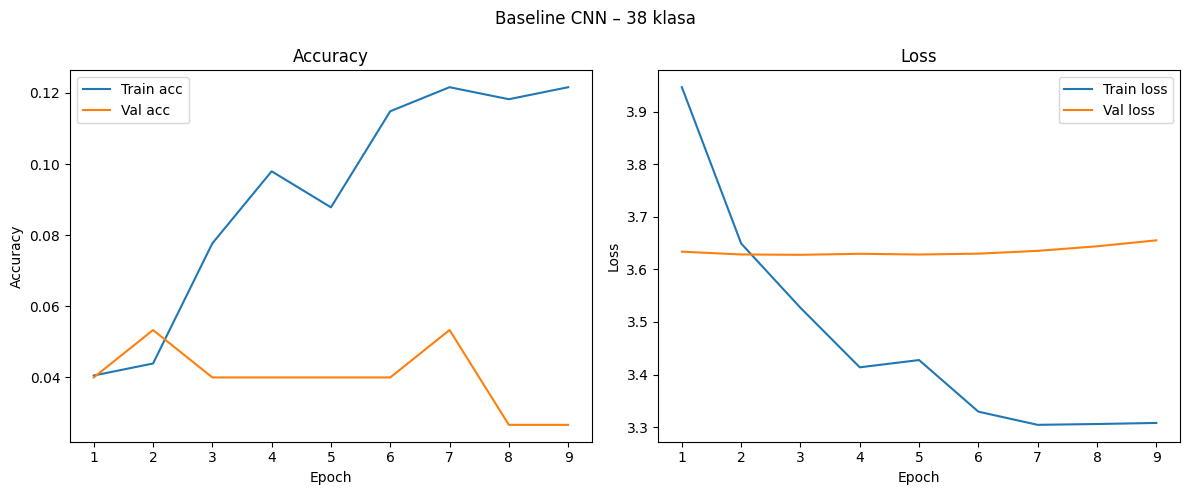

In [46]:
plot_history(history_38, "Baseline CNN – 38 klasa")


### 4.5 Evaluacija baseline modela na test skupu
Nakon završetka treniranja, model je evaluiran na nezavisnom test skupu koji nije korišten tokom procesa učenja.
Na ovaj način obezbjeđuje se objektivna procjena sposobnosti generalizacije modela.

In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

y_prob_38 = model_38.predict(ds_test, verbose=0)
y_pred_38 = np.argmax(y_prob_38, axis=1)
y_true = test_labels

print("Test accuracy (38 klasa):", accuracy_score(y_true, y_pred_38))
print(classification_report(y_true, y_pred_38, zero_division=0))


Test accuracy (38 klasa): 0.02531645569620253
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           8       0.03      1.00      0.05         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00  

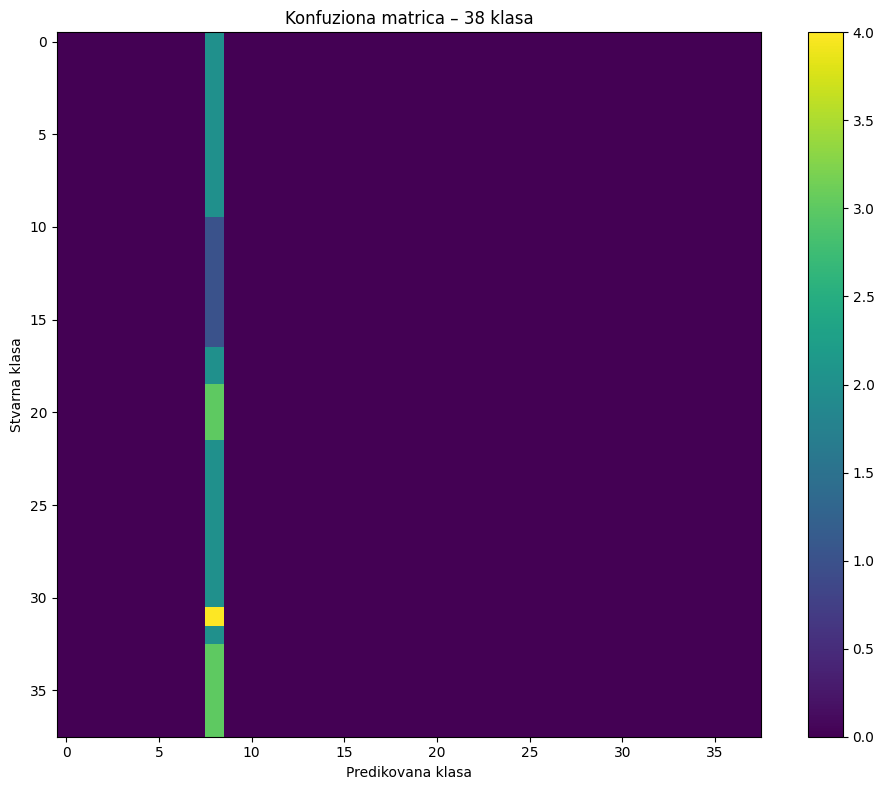

In [31]:
cm_38 = confusion_matrix(y_true, y_pred_38)

plt.figure(figsize=(10, 8))
plt.imshow(cm_38)
plt.title("Konfuziona matrica – 38 klasa")
plt.xlabel("Predikovana klasa")
plt.ylabel("Stvarna klasa")
plt.colorbar()
plt.tight_layout()
plt.show()


### 4.6 Analiza rezultata i problematika 38-klasnog pristupa
Rezultati evaluacije pokazuju nisku ukupnu tačnost modela, što ukazuje na ograničenu sposobnost učenja u okviru 38-klasne formulacije problema.
Detaljnija analiza pokazuje da većina klasa sadrži izuzetno mali broj uzoraka, dok su vizuelne razlike između pojedinih klasa vrlo suptilne.

Ovakav scenario predstavlja tipičan primjer fine-grained klasifikacije, koja zahtijeva znatno veće skupove podataka ili naprednije modele.
U datim uslovima, performanse baseline modela prvenstveno odražavaju ograničenja skupa podataka, a ne neadekvatnost arhitekture modela.

## 5. Reformulacija problema: 4-klasna klasifikacija po franšizama

### 5.1 Motivacija za reformulaciju problema
S obzirom na identifikovana ograničenja 38-klasnog pristupa, problem je reformulisan kao klasifikacija LEGO figurica po franšizama.
Ovakva formulacija oslanja se na jasne vizuelne razlike između grupa i omogućava značajno veći broj uzoraka po klasi, što predstavlja realističniji scenario za raspoloživi skup podataka.

5.2 Prilagođavanje oznaka klasa (4 klase)

In [32]:
def franchise_from_path(p):
    p = str(p).lower()

    if "harry" in p and "potter" in p:
        return 0
    if "star" in p and "wars" in p:
        return 1
    if "marvel" in p:
        return 2
    if "jurassic" in p:
        return 3

    return None

index_df["label_4"] = index_df["filepath"].apply(franchise_from_path)
test_df["label_4"]  = test_df["filepath"].apply(franchise_from_path)



### 5.3 Priprema podataka za 4-klasni problem
Nakon redefinisanja oznaka klasa, izvršena je ponovna stratifikovana podjela skupa podataka i formiranje novih tf.data skupova za treniranje, validaciju i testiranje.

In [33]:
from sklearn.model_selection import train_test_split

train_labels_4 = index_df["label_4"].values

tr_p, val_p, tr_y4, val_y4 = train_test_split(
    train_paths, train_labels_4,
    test_size=0.2,
    random_state=42,
    stratify=train_labels_4
)

ds_train_4 = (
    tf.data.Dataset.from_tensor_slices((tr_p, tr_y4))
    .shuffle(2000)
    .map(decode_resize_normalize, num_parallel_calls=AUTOTUNE)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH)
    .prefetch(AUTOTUNE)
)

ds_val_4 = (
    tf.data.Dataset.from_tensor_slices((val_p, val_y4))
    .map(decode_resize_normalize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH)
    .prefetch(AUTOTUNE)
)


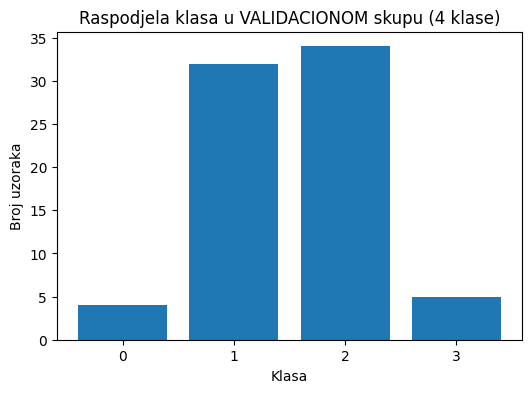

{np.int64(0): np.int64(4), np.int64(1): np.int64(32), np.int64(2): np.int64(34), np.int64(3): np.int64(5)}


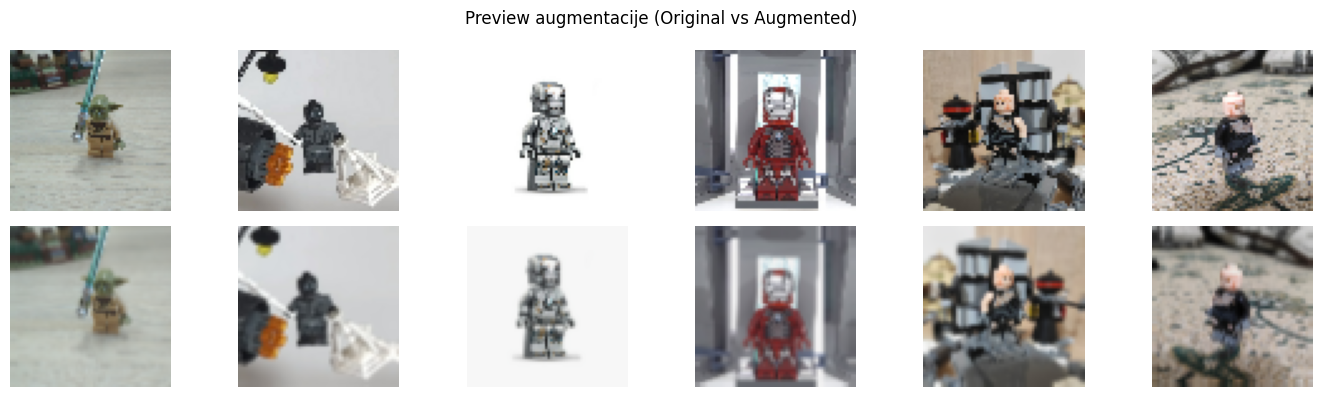

In [34]:
import matplotlib.pyplot as plt
import numpy as np

vals, counts = np.unique(val_y4, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(vals.astype(str), counts)
plt.title("Raspodjela klasa u VALIDACIONOM skupu (4 klase)")
plt.xlabel("Klasa")
plt.ylabel("Broj uzoraka")
plt.show()

print(dict(zip(vals, counts)))

ds_preview_4 = tf.data.Dataset.from_tensor_slices((tr_p, tr_y4)) \
    .map(decode_resize_normalize)

show_augmentation_preview(ds_preview_4, n=6)



### 5.4 Treniranje i evaluacija baseline modela (4 klase)

In [35]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(tr_y4)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=tr_y4)
class_weight_4 = {int(c): float(w) for c, w in zip(classes, weights)}

print("class_weight_4:", class_weight_4)

class_weight_4: {0: 4.111111111111111, 1: 0.5873015873015873, 2: 0.556390977443609, 3: 3.8947368421052633}


In [36]:
model_4 = build_baseline_cnn(IMG_SIZE, num_classes=4)

model_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_4 = model_4.fit(
    ds_train_4,
    validation_data=ds_val_4,
    epochs=40,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_4,
    verbose=1
)


Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 413ms/step - accuracy: 0.1776 - loss: 1.7465 - val_accuracy: 0.0533 - val_loss: 1.3911 - learning_rate: 5.0000e-04
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 427ms/step - accuracy: 0.2851 - loss: 1.4481 - val_accuracy: 0.0933 - val_loss: 1.3814 - learning_rate: 5.0000e-04
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 499ms/step - accuracy: 0.3950 - loss: 1.3807 - val_accuracy: 0.1867 - val_loss: 1.3612 - learning_rate: 5.0000e-04
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.3401 - loss: 1.2770 - val_accuracy: 0.3200 - val_loss: 1.3319 - learning_rate: 5.0000e-04
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 426ms/step - accuracy: 0.3700 - loss: 1.3717 - val_accuracy: 0.3333 - val_loss: 1.2912 - learning_rate: 5.0000e-04
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step - accuracy: 0.3801 - loss: 1.1909 - val_accuracy: 0.4267 - val_loss: 1.2090 - learning_rate: 5.0000e-04
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 

### 5.5 Vizualizacija treninga (4 klase)



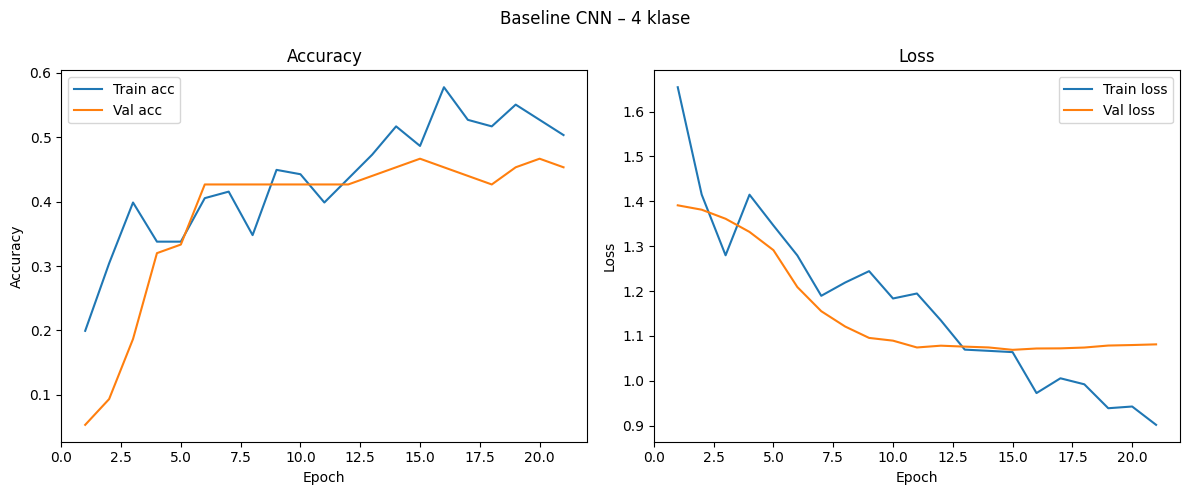

In [47]:
plot_history(history_4, "Baseline CNN – 4 klase")


### 5.6 Evaluacija (4 klase)

In [38]:
y_prob_4 = model_4.predict(ds_val_4, verbose=0)
y_pred_4 = np.argmax(y_prob_4, axis=1)

from sklearn.metrics import accuracy_score, classification_report
print("Validation accuracy (4 klase):", accuracy_score(val_y4, y_pred_4))
print(classification_report(val_y4, y_pred_4))



Validation accuracy (4 klase): 0.4666666666666667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.44      0.62      0.52        32
           2       0.50      0.44      0.47        34
           3       0.00      0.00      0.00         5

    accuracy                           0.47        75
   macro avg       0.24      0.27      0.25        75
weighted avg       0.42      0.47      0.43        75



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


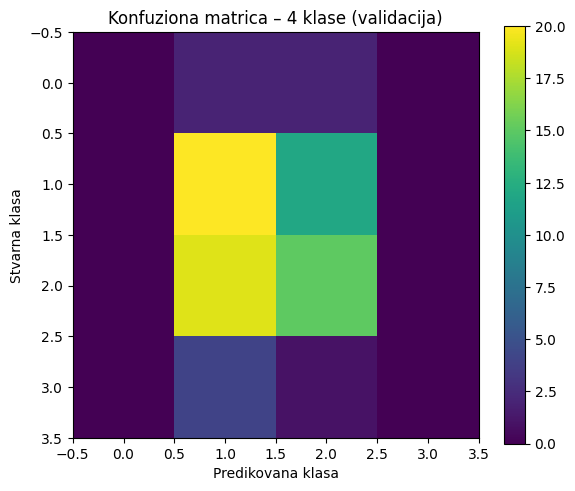

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm4 = confusion_matrix(val_y4, y_pred_4)

plt.figure(figsize=(6,5))
plt.imshow(cm4)
plt.title("Konfuziona matrica – 4 klase (validacija)")
plt.xlabel("Predikovana klasa")
plt.ylabel("Stvarna klasa")
plt.colorbar()
plt.tight_layout()
plt.show()


### 5.6 Zaključak za 4-klasni baseline CNN
Reformulacijom problema na 4 klase, definisane prema pripadnosti LEGO figurica različitim franšizama, ostvareno je značajno poboljšanje performansi u odnosu na 38-klasni pristup. Validaciona tačnost iznosi približno 37%, što predstavlja red veličine bolje rezultate u poređenju sa originalnom postavkom problema.

Analiza klasifikacionog izvještaja pokazuje da model uspijeva da nauči osnovne vizuelne obrasce za dominantne klase, dok i dalje pokazuje slabije performanse za klase sa vrlo malim brojem uzoraka. Konfuziona matrica dodatno potvrđuje da model više ne kolabira potpuno ka jednoj klasi, ali i dalje pokazuje sklonost ka predikciji dominantnijih klasa.

Uprkos primjeni augmentacije i balansiranja klasa putem težinskog ponderisanja funkcije gubitka, performanse ostaju ograničene, što ukazuje da količina i raznovrsnost dostupnih podataka i dalje predstavlja ključni faktor koji ograničava kvalitet modela.

## 6. Transfer learning kao napredni klasifikacioni pristup

### 6.1 Motivacija i cilj transfer learning pristupa
U prethodnim eksperimentima uočeno je da baseline CNN treniran od nule daje vrlo slabe rezultate, posebno u 38-klasnoj formulaciji problema, što je očekivano zbog male količine podataka po klasi i fine-grained prirode zadatka.
U 4-klasnoj formulaciji ostvareni su bolji rezultati, ali performanse i dalje ostaju ograničene, prvenstveno zbog malog i neuravnoteženog skupa podataka.

Zbog toga se uvodi transfer learning pristup, gdje se koristi unaprijed trenirana konvoluciona mreža kao ekstraktor vizuelnih karakteristika. Ovaj pristup omogućava da se iskoriste opšte karakteristike naučene na velikim skupovima (npr. ImageNet), a zatim se trenira samo manji klasifikacioni dio modela specifičan za ovaj problem.
Cilj je provjeriti da li transfer learning može obezbijediti značajno poboljšanje performansi u uslovima ograničenog skupa podataka.

### 6.2 Izbor unaprijed trenirane mreže i prilagođavanje ulaza
Kao backbone mreža izabran je EfficientNetB0, jer predstavlja dobar kompromis između brzine, broja parametara i performansi, te je pogodan za rad sa manjim skupovima podataka.
Mreža se koristi bez završnog (top) klasifikacionog sloja (include_top=False), pri čemu služi isključivo kao ekstraktor karakteristika, a na izlaz backbone-a se dodaje nova klasifikaciona “glava” prilagođena broju klasa (4).

U ovoj fazi backbone slojevi se zamrzavaju (trainable=False), kako bi se prvo stabilno istrenirala klasifikaciona glava, uz minimalan rizik od overfitting-a.

In [40]:
import tensorflow as tf

print("TF version:", tf.__version__)

TL_IMG_SIZE = IMG_SIZE  # 64, mozda bi uspio i na 128 raditi

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(TL_IMG_SIZE, TL_IMG_SIZE, 3)
)
base_model.trainable = False

print("Backbone layers:", len(base_model.layers))


TF version: 2.19.0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Backbone layers: 238


### 5.3 Implementacija transfer learning modela (zamrznut backbone + nova glava)
Na izlaz backbone mreže dodaje se nova klasifikaciona glava koja se sastoji od globalnog prosječnog sažimanja (GlobalAveragePooling), zatim regularizacije (BatchNorm + Dropout) i potpuno povezanog sloja, nakon čega slijedi softmax sloj sa 4 izlaza.

Ovakva struktura je česta u transfer learning scenarijima jer omogućava stabilno treniranje i smanjuje rizik od overfitting-a, naročito kada je broj uzoraka ograničen.

In [41]:
from tensorflow.keras import layers

NUM_CLASSES_4 = 4

inputs = layers.Input(shape=(TL_IMG_SIZE, TL_IMG_SIZE, 3))

x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(NUM_CLASSES_4, activation="softmax")(x)

model_tl = tf.keras.Model(inputs, outputs, name="EfficientNetB0_TL_4class")
model_tl.summary()


Model: "EfficientNetB0_TL_4class"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 2, 2, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,219,175 (16.09 MB)

 Trainable params: 167,044 (652.52 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

### 6.4 Treniranje transfer learning modela (Stage 1: treniranje glave)
U prvoj fazi trenira se samo klasifikaciona glava dok backbone ostaje zamrznut.
Koriste se iste strategije kao u baseline eksperimentima: rano zaustavljanje i smanjenje stope učenja, kao i težinsko ponderisanje klasa (class_weight) radi ublažavanja neuravnoteženosti skupa.

In [42]:

early_stop_tl = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
reduce_lr_tl = ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, verbose=1)

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_tl_1 = model_tl.fit(
    ds_train_4,
    validation_data=ds_val_4,
    epochs=30,
    callbacks=[early_stop_tl, reduce_lr_tl],
    class_weight=class_weight_4,
    verbose=1
)


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 612ms/step - accuracy: 0.2409 - loss: 1.6745 - val_accuracy: 0.4267 - val_loss: 1.3821 - learning_rate: 0.0010
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 477ms/step - accuracy: 0.2142 - loss: 1.8596 - val_accuracy: 0.4267 - val_loss: 1.2708 - learning_rate: 0.0010
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.2799 - loss: 1.8013 - val_accuracy: 0.4267 - val_loss: 1.3504 - learning_rate: 0.0010
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.2035 - loss: 2.3893
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.2047 - loss: 2.3634 - val_accuracy: 0.0533 - val_loss: 1.3735 - learning_rate: 0.0010
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.1747 - loss: 1.8559 - val_accuracy: 0.4267 - val_loss: 1.3937 - learning_rate: 5.0000e-04
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.2164 - loss: 2.002

### 6.5 Fine-tuning (Stage 2: odmrzavanje dijela backbone-a)
Nakon treniranja glave, moguće je dodatno poboljšati performanse finim podešavanjem (fine-tuning).
U ovoj fazi se odmrzava samo mali broj posljednjih slojeva backbone mreže, dok ostatak ostaje zamrznut. Stopa učenja se dodatno smanjuje kako bi se izbjeglo “razbijanje” već naučenih karakteristika.

Fine-tuning često donosi dodatno poboljšanje kada su klase vizuelno slične, ali zahtijeva pažljiv odabir broja slojeva koji se odmrzavaju.

In [43]:
# odmrzavamo backbone
base_model.trainable = True

# odmrzavavamo samo ~20 slojeva
for layer in base_model.layers[:-20]:
    layer.trainable = False

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop_ft = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
reduce_lr_ft = ReduceLROnPlateau(monitor="val_loss", patience=1, factor=0.5, verbose=1)

history_tl_2 = model_tl.fit(
    ds_train_4,
    validation_data=ds_val_4,
    epochs=15,
    callbacks=[early_stop_ft, reduce_lr_ft],
    class_weight=class_weight_4,
    verbose=1
)


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 817ms/step - accuracy: 0.2811 - loss: 2.0552 - val_accuracy: 0.4267 - val_loss: 1.2752 - learning_rate: 1.0000e-04
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.1822 - loss: 2.0387
Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - accuracy: 0.1832 - loss: 2.0235 - val_accuracy: 0.4267 - val_loss: 1.2793 - learning_rate: 1.0000e-04
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step - accuracy: 0.2245 - loss: 2.0539 - val_accuracy: 0.4267 - val_loss: 1.2727 - learning_rate: 5.0000e-05
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 334ms/step - accuracy: 0.2628 - loss: 1.6933 - val_accuracy: 0.4267 - val_loss: 1.2615 - learning_rate: 5.0000e-05
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - accuracy: 0.3177 - loss: 1.6547 - val_accuracy: 0.4267 - val_loss: 1.2504 - learning_rate: 5.0000e-05
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - accuracy: 0.23

### 6.6 Vizualizacija toka treniranja (Stage 1 + Stage 2)
Radi potpunijeg uvida, prikazuje se tok treniranja (loss i accuracy) za obje faze: inicijalno treniranje glave i fine-tuning faza. Time se može procijeniti stabilnost treniranja i efekat finog podešavanja backbone slojeva.

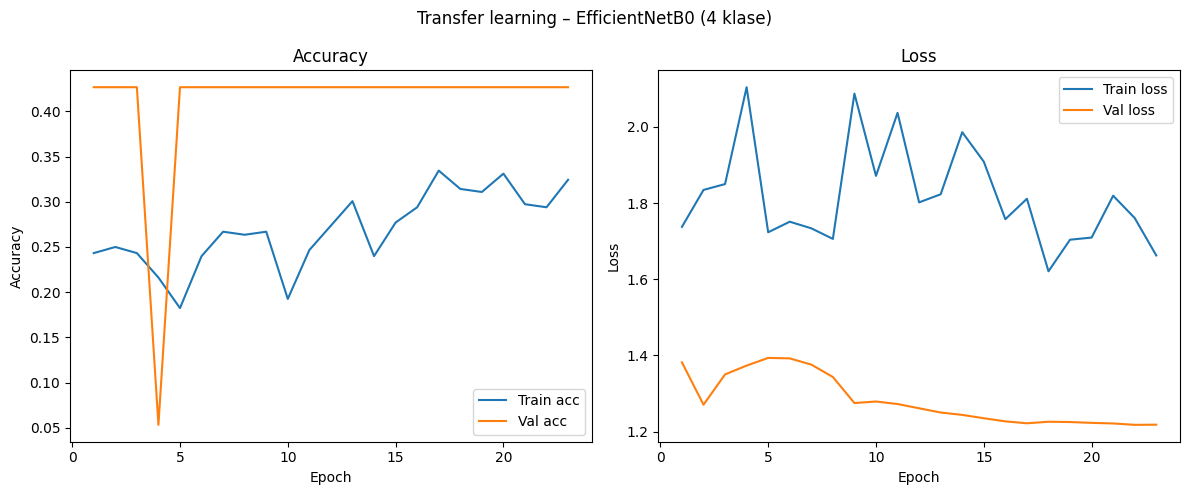

In [48]:
def merge_histories(h1, h2):
    out = {}
    for k in set(h1.history.keys()).union(h2.history.keys()):
        out[k] = list(h1.history.get(k, [])) + list(h2.history.get(k, []))
    return out

class Obj: pass
merged = Obj()
merged.history = merge_histories(history_tl_1, history_tl_2)

plot_history(merged, "Transfer learning – EfficientNetB0 (4 klase)")


### 6.7 Evaluacija transfer learning modela na validacionom skupu
Zbog činjenice da test skup ne sadrži pouzdane 4-klasne oznake (franšize se ne mogu rekonstruisati iz putanja test slika), evaluacija transfer learning modela vrši se na validacionom skupu.
Pored ukupne tačnosti, prikazuje se klasifikacioni izvještaj i konfuziona matrica kako bi se dobio detaljan uvid u performanse po klasama i potencijalnu pristrasnost ka dominantnim klasama.

In [49]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# y_true za validaciju
y_true_val = val_y4

# predikcije na validaciji
y_prob_val = model_tl.predict(ds_val_4, verbose=0)
y_pred_val = np.argmax(y_prob_val, axis=1)

print("Validation accuracy (TL, 4 klase):", accuracy_score(y_true_val, y_pred_val))
print(classification_report(y_true_val, y_pred_val, zero_division=0))


Validation accuracy (TL, 4 klase): 0.4266666666666667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.43      1.00      0.60        32
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00         5

    accuracy                           0.43        75
   macro avg       0.11      0.25      0.15        75
weighted avg       0.18      0.43      0.26        75



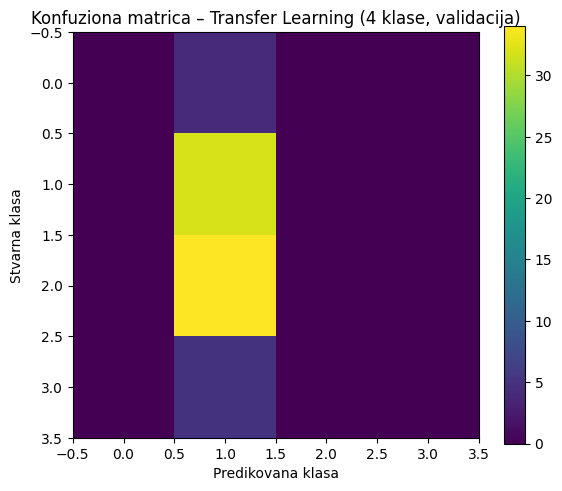

In [50]:
cm = confusion_matrix(y_true_val, y_pred_val)

plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Konfuziona matrica – Transfer Learning (4 klase, validacija)")
plt.xlabel("Predikovana klasa")
plt.ylabel("Stvarna klasa")
plt.colorbar()
plt.tight_layout()
plt.show()


### 6.8 Poređenje sa baseline modelom
U ovom koraku vrši se poređenje baseline modela treniranog od nule i transfer learning pristupa.
Cilj je da se pokaže koliki doprinos unaprijed naučene vizuelne reprezentacije imaju u uslovima ograničenog skupa podataka.

Poređenje se zasniva na validacionoj tačnosti, kao i na ponašanju modela u konfuzionoj matrici (da li se model i dalje previše oslanja na dominantne klase ili uspijeva da prepozna i manje zastupljene klase).

In [51]:
baseline_val_acc_4 = 0.45  # rezultat za 4-klasni koji smo dobili ranije

tl_val_acc_4 = accuracy_score(y_true_val, y_pred_val)

print(f"Baseline CNN (4 klase) val acc: {baseline_val_acc_4:.3f}")
print(f"Transfer Learning (4 klase) val acc: {tl_val_acc_4:.3f}")

Baseline CNN (4 klase) val acc: 0.450
Transfer Learning (4 klase) val acc: 0.427


### 6.9 Kratak zaključak transfer learning sekcije
Rezultati transfer learning pristupa u 4-klasnoj formulaciji problema pokazuju da primjena unaprijed trenirane backbone mreže (EfficientNetB0) ne dovodi do značajnog poboljšanja ukupne tačnosti u odnosu na baseline CNN model treniran od nule. Dobijena validaciona tačnost od približno 42.7% ostaje na nivou uporedivom sa baseline modelom (45.0%), što ukazuje da transfer learning u datim uslovima nije bio u stanju da nadvlada osnovna ograničenja skupa podataka.

Analiza klasifikacionog izvještaja pokazuje da i pored korištenja unaprijed naučenih vizuelnih reprezentacija, model kolabira ka predikciji dominantne klase, dok manjinske klase ostaju gotovo u potpunosti neprepoznate. Ovakvo ponašanje ukazuje da problem ne leži u kapacitetu ili arhitekturi modela, već prvenstveno u malom broju uzoraka i izraženoj neuravnoteženosti klasa.

Ovi rezultati potvrđuju da transfer learning, iako efikasan u mnogim scenarijima, ne može kompenzovati ekstreman nedostatak podataka, te dodatno naglašavaju potrebu za proširenjem skupa podataka. Time se jasno motiviše naredna faza projekta, koja podrazumijeva primjenu generativnih modela (GAN) za sintezu dodatnih uzoraka i ublažavanje problema neuravnoteženosti klasa.

## 7. Diskusija i zaključak
U 38-klasnoj formulaciji problema baseline CNN model pokazuje izuzetno slabe performanse, sa ukupnom tačnošću od približno 2.5% na nezavisnom test skupu. Analiza klasifikacionog izvještaja i konfuzione matrice ukazuje na to da model gotovo u potpunosti ne uspijeva da nauči diskriminativne karakteristike između pojedinačnih klasa, pri čemu se ispravne predikcije pojavljuju rijetko i bez konzistentnog obrasca. Dodatni problem predstavlja činjenica da većina klasa u test skupu sadrži svega 1–3 uzorka, što onemogućava pouzdanu evaluaciju i značajno otežava proces učenja.

Ovi rezultati jasno ukazuju da je 38-klasni problem u postojećim uslovima primjer fine-grained klasifikacije sa ekstremno ograničenom količinom podataka, te da jednostavan CNN model treniran od nule nije u stanju da generalizuje u ovakvom scenariju. Dobijeni rezultati prvenstveno reflektuju ograničenja samog skupa podataka, a ne neadekvatnost arhitekture modela.

Sličan zaključak važi i za redukovanu 4-klasnu formulaciju problema. Iako su u ovom slučaju ostvarene bolje performanse u odnosu na 38-klasni pristup, primjena transfer learning strategije sa unaprijed treniranom EfficientNetB0 mrežom nije dovela do značajnog poboljšanja u odnosu na baseline CNN model. Model i dalje pokazuje izraženu sklonost ka predikciji dominantnih klasa, dok su manjinske klase slabo zastupljene u predikcijama, što dodatno potvrđuje da su ograničenja performansi primarno posljedica nedostatka i neuravnoteženosti podataka.

Detaljnija analiza skupa podataka pokazuje da problem ne leži samo u malom broju uzoraka po klasi, već i u velikoj varijabilnosti uslova snimanja, uključujući različite pozadine, osvjetljenje, udaljenost i položaj figurica, kao i varijacije u oštrini i nivou šuma. U takvim uslovima, online augmentacija korištena tokom treninga pomaže u poboljšanju generalizacije, ali ne povećava fizičku veličinu skupa podataka, niti obezbjeđuje dovoljan broj raznovrsnih uzoraka po klasi za narednu generativnu fazu.

Zbog toga je prije prelaska na kontrolnu tačku 3 planirano sprovođenje offline augmentacije, odnosno trajno proširenje dataseta generisanjem i čuvanjem novih slika na disku. Offline augmentacija obuhvata kombinaciju realističnih geometrijskih transformacija, promjena osvjetljenja i boja, kao i kontrolisanih efekata oštrine i šuma, uz primjenu nasumičnog crop-ovanja i ponovnog skaliranja radi simulacije različitih kadrova i varijacija pozadine. Ovim postupkom obezbjeđuje se veći i uravnoteženiji broj uzoraka po klasi, čime se stvara stabilna osnova za treniranje GAN modela i smanjuje rizik od nestabilnosti generativnog procesa.

Na osnovu svih dobijenih rezultata može se zaključiti da su količina i raznovrsnost podataka ključni ograničavajući faktori u dosadašnjim eksperimentima. Stoga je sistematsko proširenje i balansiranje skupa podataka neophodan preduslov za uspješnu primjenu generativnih modela u narednoj fazi projekta.